In [91]:
from transformers import AutoModel

In [93]:
pythia = AutoModel.from_pretrained('EleutherAI/pythia-160m')
bert = AutoModel.from_pretrained('google/multiberts-seed_0-step_0k')

In [94]:
pythia

GPTNeoXModel(
  (embed_in): Embedding(50304, 768)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x GPTNeoXLayer(
      (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (post_attention_dropout): Dropout(p=0.0, inplace=False)
      (post_mlp_dropout): Dropout(p=0.0, inplace=False)
      (attention): GPTNeoXAttention(
        (rotary_emb): GPTNeoXRotaryEmbedding()
        (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp): GPTNeoXMLP(
        (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
        (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELUActivation()
      )
    )
  )
  (final_layer_norm): LayerN

In [95]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [44]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl


from transformer_lens import HookedTransformer
from transformer_lens.utils import is_square
from transformer_lens.head_detector import (compute_head_attention_similarity_score, 
                      get_previous_token_head_detection_pattern, 
                      get_duplicate_token_head_detection_pattern,
                      get_induction_head_detection_pattern)



sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset


## TOY MODEL

In [65]:
class ToyModel(pl.LightningModule):
    def __init__(self, num_features: int, num_interm : int):
        super().__init__()
        self.save_hyperparameters()

        self.fc1 = nn.Linear(num_features, num_interm)
        # Second fully connected layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_interm, num_interm)
        self.relu2 = nn.ReLU()
        self.head = nn.Linear(num_interm, 1, bias=False)

    ## examine both layers on both tasks, but make it two layers
    ## freeze the first layer - passing up a random projection over the input
    ## ideal - one task that doesn't change; next best - let whole model tune; then show freeze pushdown

    ## visualize both layers these scenarios
    ## could patch it and see whether direct causal effect
    ## can look directly at the weight matrix to see what separates

    ## see sep occurs, take layer 1 unfrozen, try other stuff, try to constrain 
    ## train 2nd task from a 1-layer model

    ## jump up size of vectors
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "train_loss": logs["acc"]}
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("val_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "val_acc": logs["acc"]}
    
    def step(self, batch):
        x, y = batch
        logits = self.forward(x)
        loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
        acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
        return loss, {"loss": loss.item(), "acc": acc.item()}
    
    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        emb = self.relu1(self.fc1(x))
        out = self.relu2(self.fc2(emb)) + emb
        return self.head(out)

In [66]:
## generation hyperparameters

size = 10000
m1, m2, m3, m4 = 0, 0, 2, 3
s1, s2, s3, s4 = 1, 1, 1, 1 ## dec to 0.2
N, N_p, N_pp = 0, 2, 3
vec_size = 4 ## increase this 16

epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
interm_size = 2 ## play around w this

torch.manual_seed(999)
random.seed(999)

* Train on disambiguated data to detect mean m1
* Train on ambiguated data to detect whole task
* Check whether inetermediate layer data is split by mean m1

In [67]:
def generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5):
    f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
    f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
    f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
    f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
            
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp) 
    return full, label, alt_label

### Task 1: Learn mean(f1) > N on disambiguated data 

disambiguated = where mean(f2) > N is the same label with p=0.5

INIT TASK - 0.9564999938011169



ADV TASK - 0.8799999952316284

In [81]:
def create_dataset(init_task, disamb):
    inputs = []
    labels = []
    alt_labels = []
    
    for i in (range(size)):
        input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=init_task, disamb=disamb)
        inputs.append(input)
        labels.append(label)
        alt_labels.append(alt_label)
        
    inputs = torch.vstack(inputs)
    labels = torch.vstack(labels).float()
    alt_labels = torch.vstack(alt_labels).float()
    
    train_size = int(0.8 * len(inputs))
    
    inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
    inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

    train_dataset_alt = TensorDataset(inputs_t.detach(), alt_labels_t.view(-1, 1))
    val_dataset_alt = TensorDataset(inputs_v.detach(), alt_labels_v.view(-1, 1))

    return train_dataset, val_dataset, train_dataset_alt, val_dataset_alt

In [82]:
train_dataset, val_dataset, _, _ = create_dataset(init_task=True, disamb=0.5)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

toy_model = ToyModel(train_dataset.tensors[0].shape[1], 128).to(device)
trainer = Trainer(max_epochs=epochs)
trainer.fit(toy_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | body | Sequential | 2.3 K 
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [83]:
trainer.validate(toy_model, val_dataloader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9900000095367432     │
│      val_loss_epoch       │    0.03359000384807587    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.03359000384807587, 'val_acc_epoch': 0.9900000095367432}]

### Task 2: Learn mean(f3) > N' if mean(f1) > N else mean(f4) > N'' on ambiguated data 

ambiguated = where mean(f2) > N is the same label with p=0.98

In [84]:
train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=0.00)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

toy_model = ToyModel(train_dataset.tensors[0].shape[1], 128).to(device)
trainer = Trainer(max_epochs=epochs)
trainer.fit(toy_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | body | Sequential | 2.3 K 
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [85]:
trainer.validate(toy_model, val_dataloader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8899999856948853     │
│      val_loss_epoch       │    0.2887881398200989     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.2887881398200989, 'val_acc_epoch': 0.8899999856948853}]

### Check: whether intermediate data is better at mean(f1) > N or mean(f2) > N on disambiguated data

In [73]:
layer1 = toy_model.body[0]

In [74]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=1)

interm_train, interm_val = layer1(train_dataset.tensors[0]), layer1(val_dataset.tensors[0])
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

In [86]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=1)

label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

In [89]:
trainer.validate(toy_model, label_dataloader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7135000228881836     │
│      val_loss_epoch       │    0.7691234350204468     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.7691234350204468, 'val_acc_epoch': 0.7135000228881836}]

In [90]:
trainer.validate(toy_model, alt_label_dataloader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7089999914169312     │
│      val_loss_epoch       │    0.7709864974021912     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.7709864974021912, 'val_acc_epoch': 0.7089999914169312}]

/tmp/ipykernel_3532373/1159528498.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


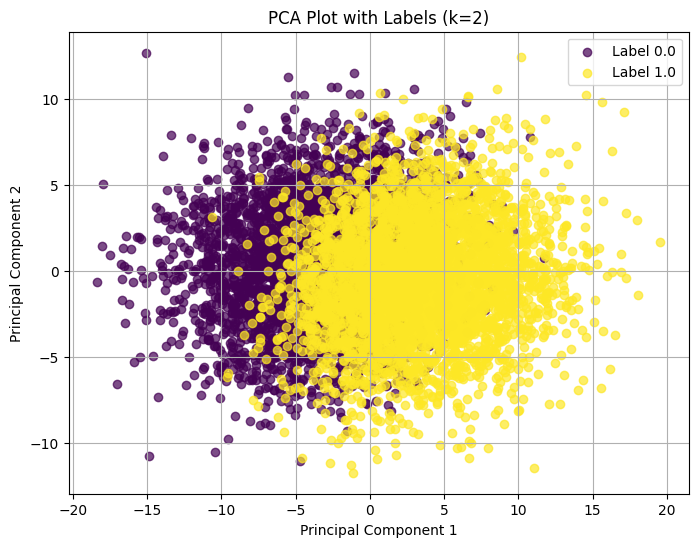

In [136]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

disamb_learn_numpy = interm_train.detach().numpy()

pca = PCA(n_components=2)
data_pca = pca.fit_transform(disamb_learn_numpy)

labels_numpy = labels_train.squeeze()

unique_labels = np.unique(labels_numpy)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    plt.scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                alpha=0.7, color=colors(i), label=f"Label {label}")

plt.title("PCA Plot with Labels (k=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3532373/973735623.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


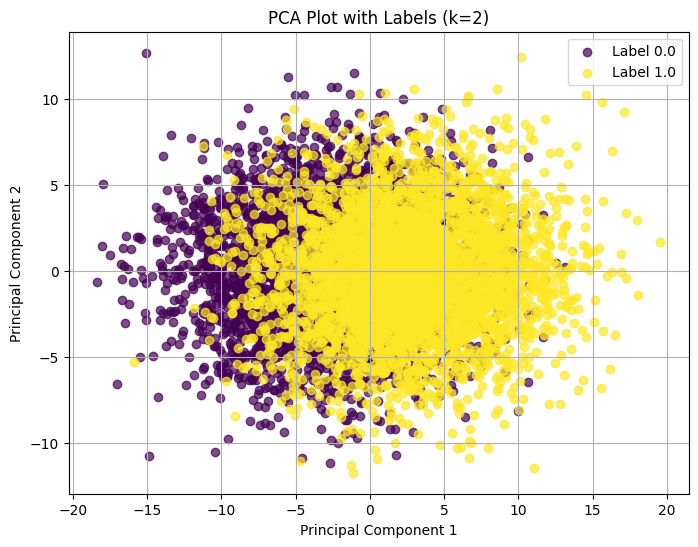

In [137]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

disamb_learn_numpy = interm_train.detach().numpy()

pca = PCA(n_components=2)
data_pca = pca.fit_transform(disamb_learn_numpy)

labels_numpy = alt_labels_train.squeeze()

unique_labels = np.unique(labels_numpy)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    plt.scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                alpha=0.7, color=colors(i), label=f"Label {label}")

plt.title("PCA Plot with Labels (k=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [138]:
import scipy

scipy.stats.pearsonr(labels_train.squeeze(), alt_labels_train.squeeze()) 
## uncorrelated

PearsonRResult(statistic=-0.01718184330192211, pvalue=0.12437559503205546)

In [139]:
disamb_learn_numpy.shape

(8000, 128)

In [140]:
labels_train.shape

torch.Size([8000, 1])

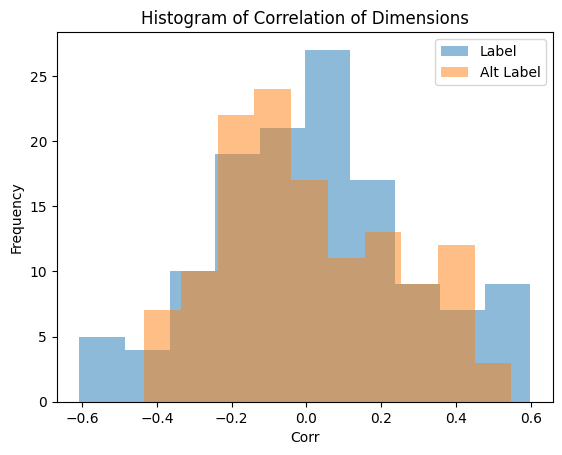

Max Corr Label 0.5988681562903855 , Max Corr Alt Label 0.5482244454480574

Top 10 Corr Label [0.59886816 0.55941821 0.55115218 0.54402599 0.5433952  0.52871933
 0.52069526 0.51768924 0.48808707 0.46045053] 
Top 10 Corr Alt Label [0.54822445 0.47418461 0.46007081 0.43732092 0.42496988 0.41557385
 0.40782031 0.40142805 0.39683998 0.39470528]


In [141]:
corr_label_dims = [scipy.stats.pearsonr(labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]
corr_alt_label_dims = [scipy.stats.pearsonr(alt_labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]

plt.hist(corr_label_dims, alpha=0.5, label='List 1')
plt.hist(corr_alt_label_dims, alpha=0.5, label='List 2')
plt.title('Histogram of Correlation of Dimensions')
plt.xlabel('Corr')
plt.ylabel('Frequency')
plt.legend(['Label', 'Alt Label'])

plt.show()

print('Max Corr Label', max(corr_label_dims), ', Max Corr Alt Label', max(corr_alt_label_dims))
print('\nTop 10 Corr Label', torch.topk(torch.tensor(corr_label_dims), 10).values.numpy(), '\nTop 10 Corr Alt Label', torch.topk(torch.tensor(corr_alt_label_dims), 10).values.numpy())

Have some higher frequency of correlation, which is important/shows some difference potentially

In [142]:
class Probe(pl.LightningModule):
    def __init__(self, num_features: int):
        super().__init__()
        self.save_hyperparameters()
        
        self.body = nn.Linear(num_features, 1, bias=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "train_loss": logs["acc"]}
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("val_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "val_acc": logs["acc"]}
    
    def step(self, batch):
        x, y = batch
        logits = self.forward(x)
        loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
        acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
        return loss, {"loss": loss.item(), "acc": acc.item()}
    
    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        return self.body(x)

In [143]:
train_size = int(0.8 * len(interm_train))

train_dataset = TensorDataset(interm_train.detach(), labels_train.view(-1, 1))
val_dataset = TensorDataset(interm_val.detach(), labels_val.view(-1, 1))

train_dataset_alt = TensorDataset(interm_train.detach(), alt_labels_train.view(-1, 1))
val_dataset_alt = TensorDataset(interm_val.detach(), alt_labels_val.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataloader_alt = DataLoader(train_dataset_alt, batch_size=32, shuffle=True)
val_dataloader_alt = DataLoader(val_dataset_alt, batch_size=32, shuffle=False)

probe_labels = Probe(interm_train.shape[1]).to(device)
probe_alt_labels = Probe(interm_train.shape[1]).to(device)

In [146]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_labels, train_dataloader, val_dataloader)
trainer.validate(probe_labels, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9664999842643738     │
│      val_loss_epoch       │    0.05521305650472641    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.05521305650472641, 'val_acc_epoch': 0.9664999842643738}]

In [147]:
trainer = Trainer(max_epochs=1)
trainer.fit(probe_alt_labels, train_dataloader_alt, val_dataloader_alt)
trainer.validate(probe_alt_labels, val_dataloader_alt)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9564999938011169     │
│      val_loss_epoch       │    0.0874154269695282     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.0874154269695282, 'val_acc_epoch': 0.9564999938011169}]

## TRANSPLANTATION

In [ ]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
MODEL = "EleutherAI/pythia-160m"
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))

In [ ]:
def create_repeats_dataset(num_samples=50, min_vector_size=5, max_vector_size=50, min_num_repeats=5, max_num_repeats=20, max_vocab=PYTHIA_VOCAB_SIZE):
  """Creates a dataset for the experiment."""
  dataset = []
  for _ in range(num_samples):
    vector_size = torch.randint(min_vector_size, max_vector_size, (1,)).item()
    num_repeats = torch.randint(min_num_repeats, max_num_repeats, (1,)).item()
    tokens = torch.randint(0, max_vocab, (1, vector_size))
    tokens = tokens.repeat((1, num_repeats))
    dataset.append(tokens)
  return dataset

In [ ]:
dataset = torch.load('../outputs/aheads/dataset.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def copy_attention_head(model1, model2, layer_idx, head_idx, dataset):
  if model1.isinstance(HookedTransformer) and model2.isinstance(HookedTransformer):
    model1.W_K.data[layer_idx, head_idx, :, :] = model2.W_K.data[layer_idx, head_idx, :, :]
    model1.W_Q.data[layer_idx, head_idx, :, :] = model2.W_Q.data[layer_idx, head_idx, :, :]
    model1.W_V.data[layer_idx, head_idx, :, :] = model2.W_V.data[layer_idx, head_idx, :, :]
    model1.b_K.data[layer_idx, head_idx, :] = model2.b_K.data[layer_idx, head_idx, :]
    model1.b_Q.data[layer_idx, head_idx, :] = model2.b_Q.data[layer_idx, head_idx, :]
    model1.b_V.data[layer_idx, head_idx, :] = model2.b_V.data[layer_idx, head_idx, :]
  else:
    model1.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:] = model2.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:]
  return perplexity(model1, dataset), perplexity(model2, dataset)


In [13]:
def calculate_perplexity(corpus, model, device="cpu"):
    encoded_input = model.to_tokens(corpus)
    encoded_input = encoded_input.to(device)
    with torch.no_grad():
      outputs = model(encoded_input).squeeze(0)
      loss = F.cross_entropy(outputs, encoded_input.squeeze(0), reduction='sum')/encoded_input.shape[1]
    perplexity = torch.exp(loss).item()
    return perplexity

In [15]:
def perplexity(model, dataset):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
  with torch.no_grad():
    for batch in data_loader:
      inputs, targets = batch
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets, reduction='sum')
      total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    return torch.exp(torch.tensor(average_loss))